In [1]:
import dac
from dac.model.dac import EncoderBlock, DecoderBlock, ResidualUnit
from dac.nn.layers import Snake1d
from audiotools import AudioSignal
import torch
from torch import nn
import copy
import matplotlib.pyplot as plt
import numpy as np

/home/archerdw/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [ ]:
# dataset = {}
# for split in ["train", "test"]:
#     dataset[split] = CIFAR10(
#     root="data/cifar10",
#     train=(split == "train"),
#     download=True,
#     transform=transforms[split],
# )

# dataloader = {}
# for split in ['train', 'test']:
#     dataloader[split] = DataLoader(
#     dataset[split],
#     batch_size=512,
#     shuffle=(split == 'train'),
#     num_workers=0,
#     pin_memory=True,
# )

In [2]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)
print("done loading")

/home/archerdw/.local/lib/python3.9/site-packages/audiotools/ml/layers/base.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(location, "cpu")


[codebook size] 1024
[# codebooks] 9
[ignore left crop] False
[encoder causal] False
[encoder frame indep] False


/home/archerdw/.local/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


[decoder causal] False
[decoder frame indep] False
[# trainable params] 76651890
[# trainable params (enc)] 22307968
[# trainable params (dec)] 54104162
done loading


In [3]:
model.eval()

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

IndexError: index 16 is out of bounds for axis 0 with size 16

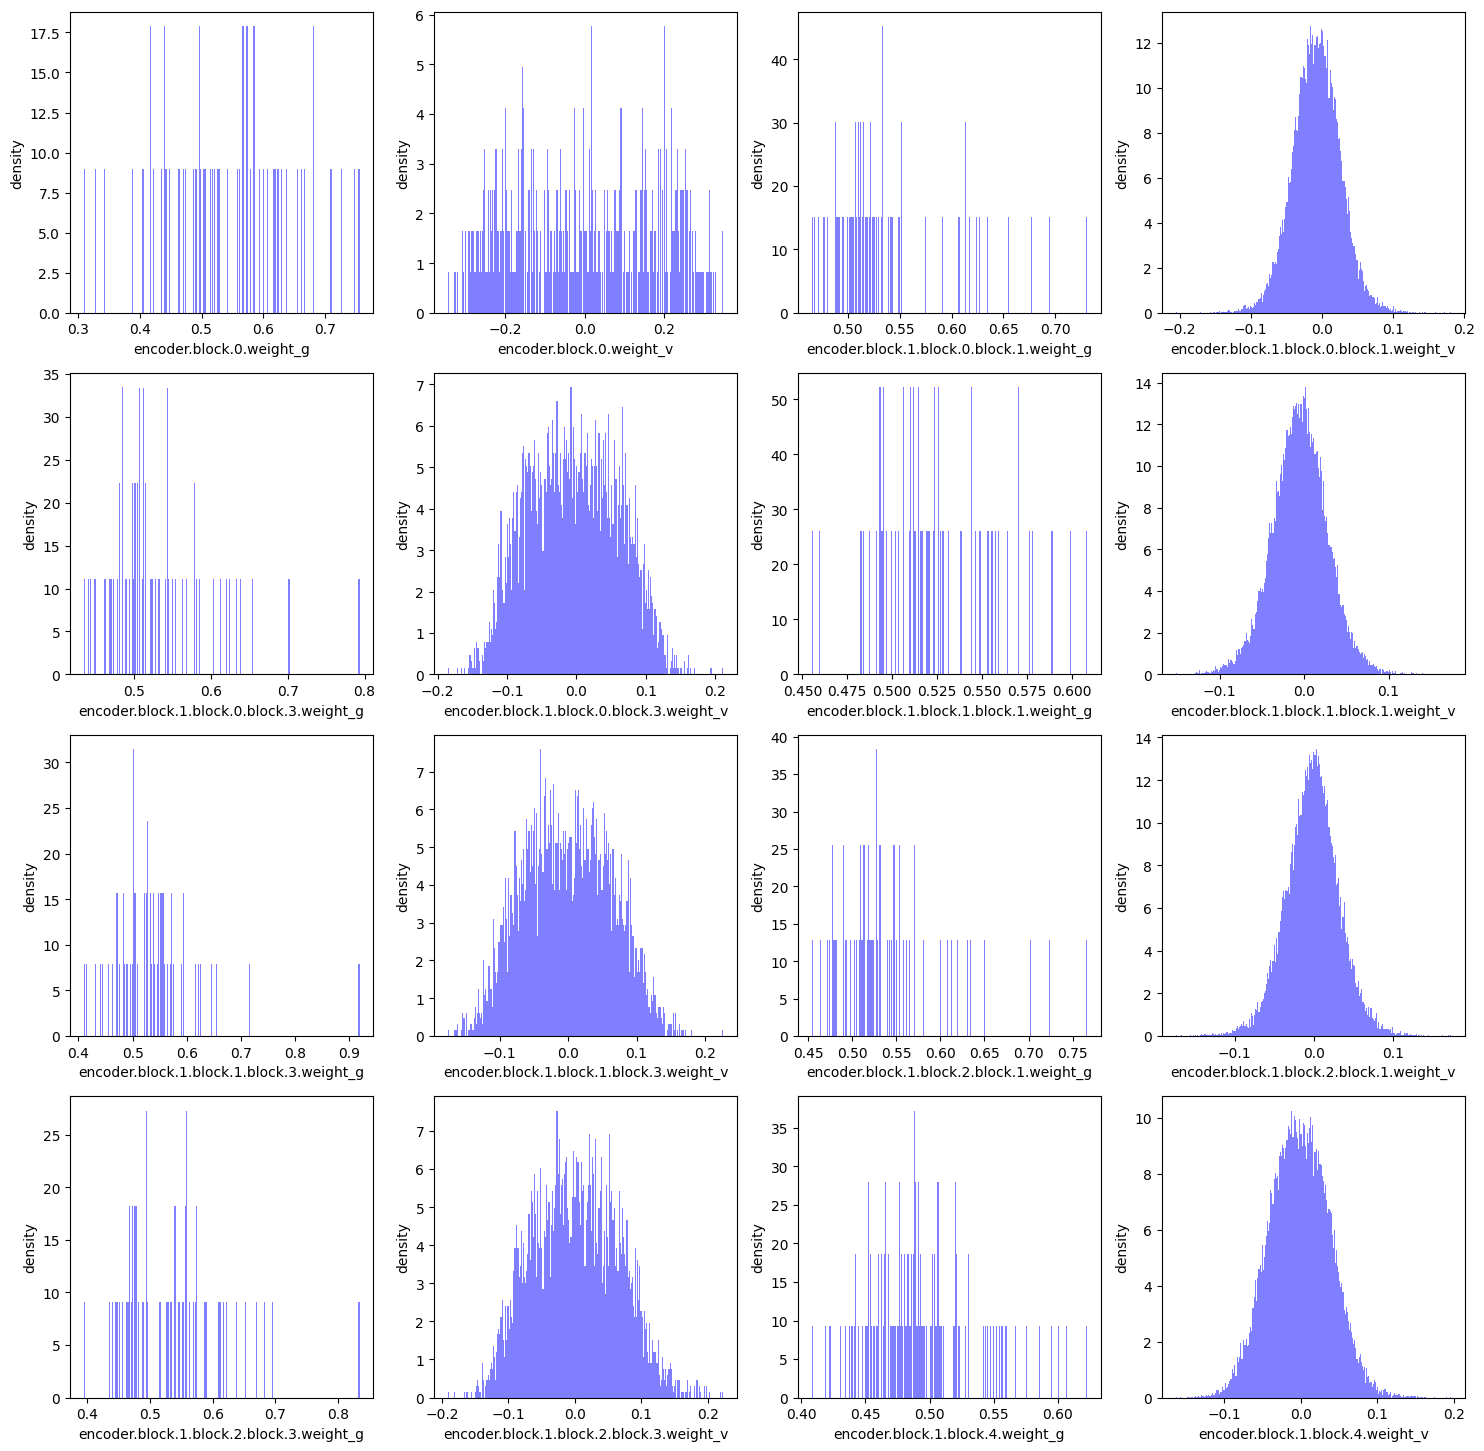

In [4]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and 'weight' in name:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

# recover_model()
plot_weight_distribution(model)

In [4]:
weight_bitwidth = 8
feature_bitwidth = 8

def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = int(round(quantized_min - fp_min / scale))
    ############### YOUR CODE ENDS HERE #################

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

In [5]:
def remove_wn(layers):
    for idx, layer in enumerate(layers):
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            wn_removed_layer = nn.utils.remove_weight_norm(layer)
            layers[idx] = wn_removed_layer
        elif hasattr(layer, 'block'):
            remove_wn(layer.block)

remove_wn(model.encoder.block)
remove_wn(model.decoder.model)

IndexError: index 16 is out of bounds for axis 0 with size 16

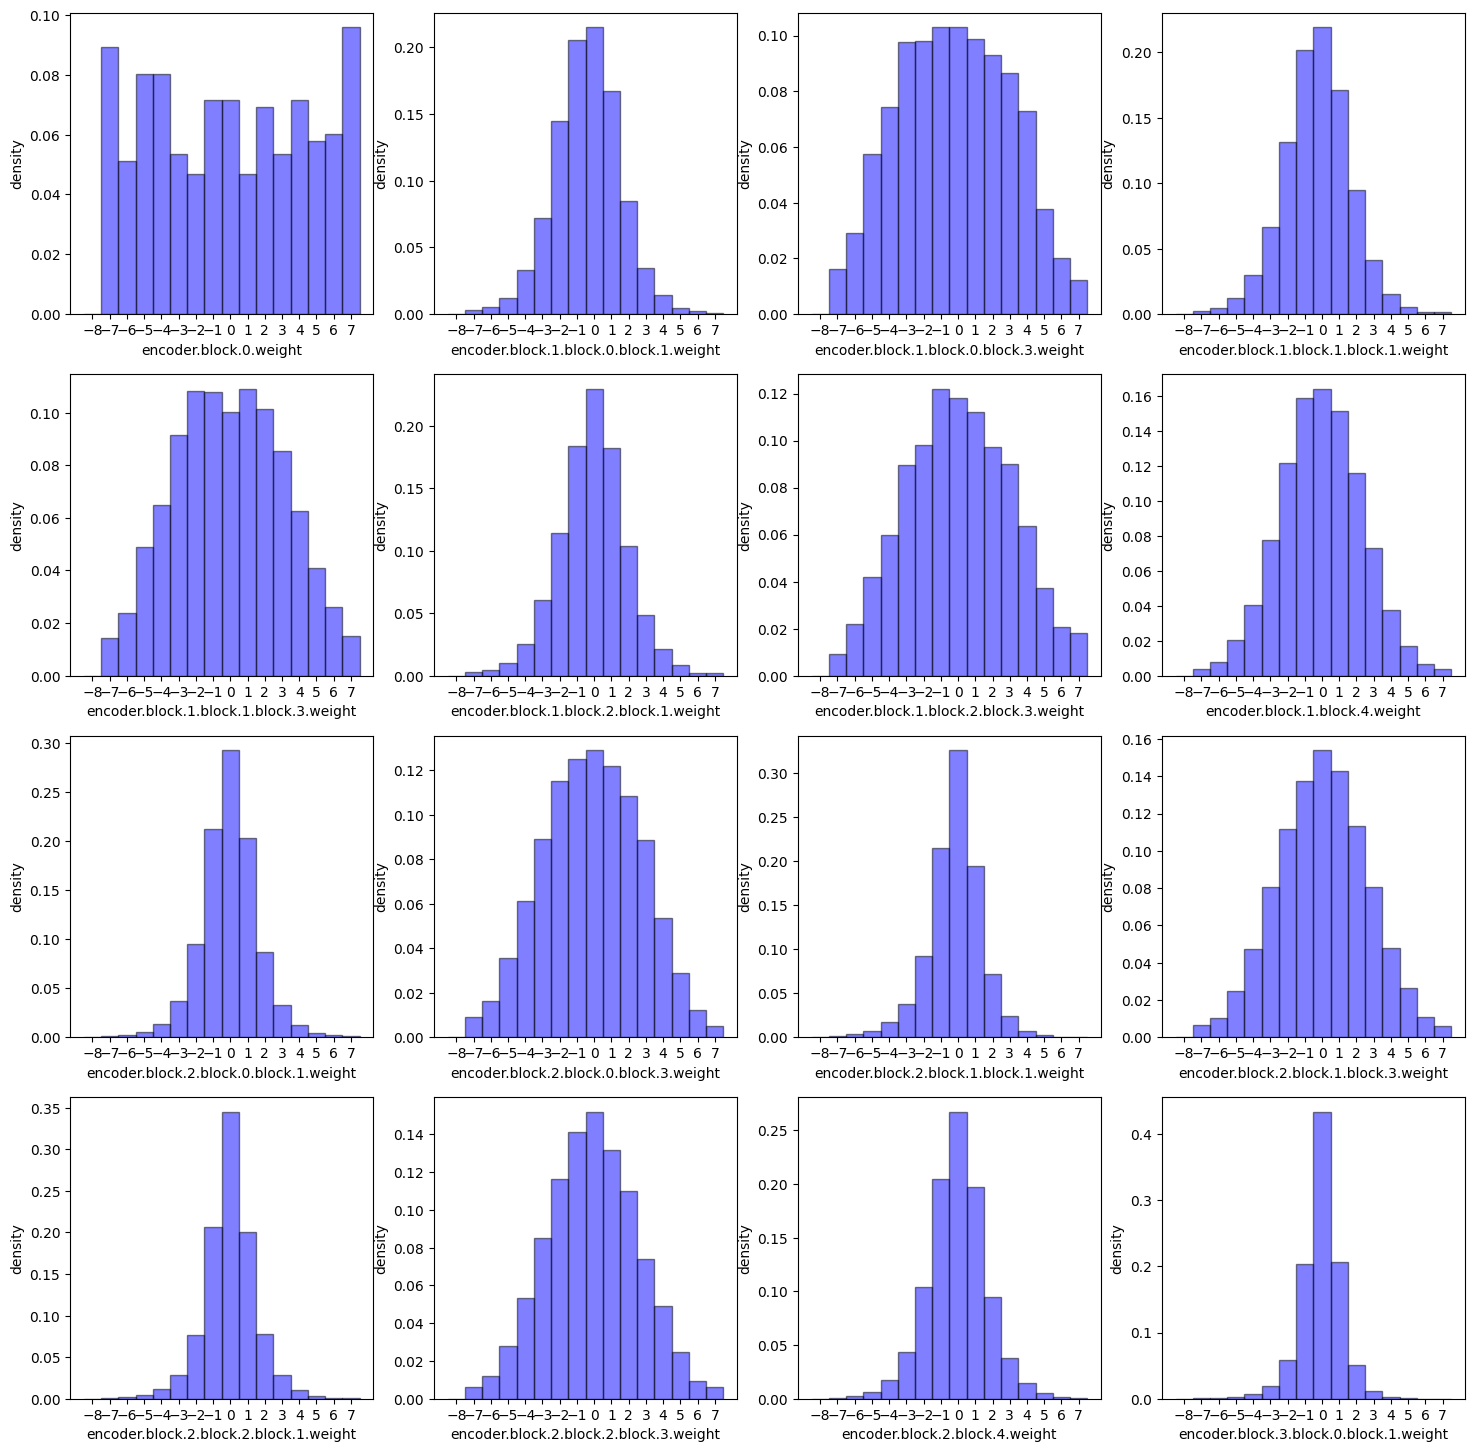

In [8]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

In [6]:
ct = 0
for name, m in model.named_modules():
    if isinstance(m, (nn.Conv1d, Snake1d)):
        # setattr(model, name, nn.Linear(module.in_features, module.out_features + 5))
        print(name, m)
        # print(name, m.padding[0], len(m.padding))
        ct += 1
        if ct == 5:
            break

encoder.block.0 Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
encoder.block.1.block.0.block.0 Snake1d()
encoder.block.1.block.0.block.1 Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
encoder.block.1.block.0.block.2 Snake1d()
encoder.block.1.block.0.block.3 Conv1d(64, 64, kernel_size=(1,), stride=(1,))


In [31]:
def shift_quantized_conv1d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2)).to(torch.int32) * input_zero_point # change

def quantized_conv1d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 2)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############
    # hint: this code block should be the very similar to quantized_linear()

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1, 1, 1) / output_scale)

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

class QuantizedConv1d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv1d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

In [8]:
# We will run the model with some sample data to get the range of each feature map, 
# so that we can get the range of the feature maps and compute their corresponding scaling factors and zero points.

# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv1d)): # exclude Snake1d?
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model)
# sample_data = iter(dataloader['train']).__next__()[0]

# Test sample input??
sample_data = torch.randn(1, 1, 512)
model(sample_data)

# remove hooks
for h in hooks:
    h.remove()


[W1127 12:57:13.763256201 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


In [9]:
for name, module in model.named_children():
    try:
        copy.deepcopy(module)
    except Exception as e:
        print(f"Error copying module {name}: {e}")

Error copying module quantizer: unsupported operand type(s) for %: 'list' and 'int'


In [32]:
import io

# Use BytesIO to avoid file I/O
buffer = io.BytesIO()

torch.save(model, buffer)
buffer.seek(0)  # Reset buffer position
quantized_model = torch.load(buffer)

feature_bitwidth = weight_bitwidth = 8

# quantized_model = torch.load(torch.save(model, None))

# quantized_model = copy.deepcopy(model)

ct = 0
for name, conv in model.named_modules():
    if isinstance(conv, (nn.Conv1d)): # exclude Snake1d
        conv_name = name
        
        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[conv_name], feature_bitwidth)
        
        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        
        shifted_quantized_bias = \
            shift_quantized_conv1d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv1d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )
        print(quantized_conv, name)
        # Split the name to identify the parent module and the target module
        parent_name = ".".join(name.split(".")[:-1])  # Parent module
        child_name = name.split(".")[-1]  # Target module
        
        # Get the parent module
        parent_module = quantized_model.get_submodule(parent_name) if parent_name else quantized_model

        # Replace the target module
        setattr(parent_module, child_name, quantized_conv)
        # setattr(quantized_model, name, quantized_conv)
        # ct += 1
        # if ct == 5:
        #     break
# quantized_backbone = []
# ptr = 0
# while ptr < len(quantized_model.backbone):
#     if isinstance(quantized_model.backbone[ptr], nn.Conv1d) and isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
#         conv = quantized_model.backbone[ptr]
#         conv_name = f'backbone.{ptr}'
#         relu = quantized_model.backbone[ptr + 1]
#         relu_name = f'backbone.{ptr + 1}'

#         input_scale, input_zero_point = \
#             get_quantization_scale_and_zero_point(
#                 input_activation[conv_name], feature_bitwidth)

#         output_scale, output_zero_point = \
#             get_quantization_scale_and_zero_point(
#                 output_activation[relu_name], feature_bitwidth)

#         quantized_weight, weight_scale, weight_zero_point = \
#             linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
#         quantized_bias, bias_scale, bias_zero_point = \
#             linear_quantize_bias_per_output_channel(
#                 conv.bias.data, weight_scale, input_scale)
        
#         shifted_quantized_bias = \
#             shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
#                                         input_zero_point)

#         quantized_conv = QuantizedConv1d(
#             quantized_weight, shifted_quantized_bias,
#             input_zero_point, output_zero_point,
#             input_scale, weight_scale, output_scale,
#             conv.stride, conv.padding, conv.dilation, conv.groups,
#             feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
#         )

#         quantized_backbone.append(quantized_conv)
#         ptr += 2
        

/tmp/ipykernel_6050/686178439.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  quantized_model = torch.load(buffer)


QuantizedConv1d() encoder.block.0
QuantizedConv1d() encoder.block.1.block.0.block.1
QuantizedConv1d() encoder.block.1.block.0.block.3
QuantizedConv1d() encoder.block.1.block.1.block.1
QuantizedConv1d() encoder.block.1.block.1.block.3
QuantizedConv1d() encoder.block.1.block.2.block.1
QuantizedConv1d() encoder.block.1.block.2.block.3
QuantizedConv1d() encoder.block.1.block.4
QuantizedConv1d() encoder.block.2.block.0.block.1
QuantizedConv1d() encoder.block.2.block.0.block.3
QuantizedConv1d() encoder.block.2.block.1.block.1
QuantizedConv1d() encoder.block.2.block.1.block.3
QuantizedConv1d() encoder.block.2.block.2.block.1
QuantizedConv1d() encoder.block.2.block.2.block.3
QuantizedConv1d() encoder.block.2.block.4
QuantizedConv1d() encoder.block.3.block.0.block.1
QuantizedConv1d() encoder.block.3.block.0.block.3
QuantizedConv1d() encoder.block.3.block.1.block.1
QuantizedConv1d() encoder.block.3.block.1.block.3
QuantizedConv1d() encoder.block.3.block.2.block.1
QuantizedConv1d() encoder.block.

In [33]:
quantized_model

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): QuantizedConv1d()
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): QuantizedConv1d()
              (2): Snake1d()
              (3): QuantizedConv1d()
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): QuantizedConv1d()
              (2): Snake1d()
              (3): QuantizedConv1d()
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): QuantizedConv1d()
              (2): Snake1d()
              (3): QuantizedConv1d()
            )
          )
          (3): Snake1d()
          (4): QuantizedConv1d()
        )
      )
      (2): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
             

In [29]:
audio_file_path = "f1_script1_iphone_balcony1.wav"
signal = AudioSignal(audio_file_path)

signal = signal.cpu()
print(signal.shape)
# x = model.compress(signal)

# # Save and load to and from disk
# x.save("compressed.dac")
# x = dac.DACFile.load("compressed.dac")

# # Decompress it back to an AudioSignal
# y = model.decompress(x)



torch.Size([1, 1, 7539712])


In [34]:
x = quantized_model.compress(signal)

AssertionError: 

In [5]:
# model.qconfig = torch.ao.quantization.get_default_qconfig('x86')

In [6]:
# model_fp32_prepared = model # torch.ao.quantization.prepare(model)
# input_fp32 = torch.randn(1, 1, 7539)
# model_fp32_prepared(input_fp32)


{'audio': tensor([[[-0.1373, -0.1210, -0.3083,  ..., -0.0587,  0.1481,  0.2086]]],
        grad_fn=<SliceBackward0>),
 'z': tensor([[[-2.7376, -5.9216,  0.1534,  ...,  0.0890, -1.9257, -3.3301],
          [ 3.7167, -0.2829, -2.7268,  ...,  7.0995,  2.1479, -0.1615],
          [ 4.7342, -6.3042, -4.4666,  ...,  1.9308, -3.1288,  1.8012],
          ...,
          [-0.4077,  2.9430, -6.8092,  ..., -2.7056,  1.0259, -6.5504],
          [-5.8558, -3.9825,  0.2893,  ..., -3.9748, -5.7457, -5.4240],
          [ 3.6048,  5.4514, -2.6522,  ..., -5.2044, -0.1594, -0.8426]]],
        grad_fn=<AddBackward0>),
 'codes': tensor([[[ 252,  329,  581, 1003,  207,  699,  387,  849,  123,  913,  790,
            160,  160,  807,  550],
          [  65,   47,  776,  530,  529, 1009,  942,  168,  234,  480,  132,
            799,  340,  761,  766],
          [ 769,  749,   80,  139,   70,  973,  956,  652,  829,  313,  891,
            891,  486,  121,  156],
          [ 808,  790,  918,  727,  189,  683, 

In [7]:
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [3]:
# Quantization 
import torch
import torch_tensorrt

# from torch.quantization import quantize_dynamic, quantize_static, prepare, convert

# Stuff to try
# 1. Linear quantization r = S(q-z)
# 2. AWQ (activation-aware weight quantization)

ModuleNotFoundError: No module named 'torch_tensorrt'

In [8]:


##########SAVE##############
# Save and load to and from disk
x.save("compressed.dac")
x = dac.DACFile.load("compressed.dac")

# Decompress it back to an AudioSignal
y = model.decompress(x)

# Write to file
y.write('output.wav')

#################################


/home/gridsan/awang2/.local/lib/python3.9/site-packages/audiotools/core/audio_signal.py:501: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(
/home/gridsan/awang2/.local/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 